In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from energydisaggregation.models.stat_model import (
    Stats,
    preprocess,
    split_year,
)

## Data processsing

### Collect source variables (Date, Région, Temperature, ER, ET, GR, GT)

In [2]:
# Import data
df_src = pd.read_csv(
    "EnergyDisaggregation/energydisaggregation/data_storage/df_process.csv",
    sep=",",
)
# df_src.info()
df_src.columns

Index(['Date - Heure', 'Région', 'consommation brute électricité (mw) - rte',
       'température (°c)', 'nebulosité totale', 'vitesse du vent moyen 10 mn',
       'humidité', 'vitesse du vent en km/h', 'température ressentie',
       'saison', 'week_day', 'month', 'hour', 'is_holiday', 'is_bank_holiday',
       'day_of_year', 'years', 'regions', 'temperature_seuil', 'saturation',
       'diff_seuil', 'température ressentie.1', 'température (°c)_mean_48',
       'température (°c)_std_48', 'température (°c)_max_48',
       'température (°c)_min_48', 'nebulosité totale_mean_3',
       'nebulosité totale_std_3', 'month_sin', 'month_cos', 'week_day_sin',
       'week_day_cos', 'hour_sin', 'hour_cos',
       'consommation brute électricité (mw) - rte_lag_1',
       'consommation brute électricité (mw) - rte_lag_2',
       'consommation brute électricité (mw) - rte_lag_3',
       'consommation brute électricité (mw) - rte_lag_4',
       'consommation brute électricité (mw) - rte_lag_5',
    

In [3]:
df_X = df_src.copy()

vars_selected = [
    "Date - Heure",
    "température (°c)",
    "Région",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "consommation brute électricité (mw) - rte",
    "consommation brute électricité (mw) - rte_lag_1",
    "consommation brute électricité (mw) - rte_lag_2",
    "consommation brute électricité (mw) - rte_lag_3",
    "consommation brute électricité (mw) - rte_lag_4",
    "consommation brute électricité (mw) - rte_lag_5",
    "consommation brute électricité (mw) - rte_lag_6",
    "consommation brute électricité (mw) - rte_lag_7",
    "température (°c)_lag_1",
    "température (°c)_lag_2",
    "température (°c)_lag_3",
    "température (°c)_lag_4",
    "température (°c)_lag_5",
    "température (°c)_lag_6",
    "température (°c)_lag_7",
]
df_X = df_X[vars_selected]


# We truncate "Date - Heure" so that we only keep the Date
def truncate(s, start=0, end=10):
    return s[start:end]


var = "Date - Heure"
res_map = map(truncate, df_src[var])
date_truncated = pd.Series(np.array(list(res_map)))
date_truncated = pd.to_datetime(date_truncated, format="%Y-%m-%d")
df_X["Date - Heure"] = date_truncated

In [4]:
vars_X = [
    "Date",
    "Temp",
    "Région",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "ce",
    "ce1",
    "ce2",
    "ce3",
    "ce4",
    "ce5",
    "ce6",
    "ce7",
    "Temp1",
    "Temp2",
    "Temp3",
    "Temp4",
    "Temp5",
    "Temp6",
    "Temp7",
]
renamed_vars = dict(zip(vars_selected, vars_X))
renamed_vars

{'Date - Heure': 'Date',
 'température (°c)': 'Temp',
 'Région': 'Région',
 'saison': 'saison',
 'week_day': 'week_day',
 'is_holiday': 'is_holiday',
 'is_bank_holiday': 'is_bank_holiday',
 'consommation brute électricité (mw) - rte': 'ce',
 'consommation brute électricité (mw) - rte_lag_1': 'ce1',
 'consommation brute électricité (mw) - rte_lag_2': 'ce2',
 'consommation brute électricité (mw) - rte_lag_3': 'ce3',
 'consommation brute électricité (mw) - rte_lag_4': 'ce4',
 'consommation brute électricité (mw) - rte_lag_5': 'ce5',
 'consommation brute électricité (mw) - rte_lag_6': 'ce6',
 'consommation brute électricité (mw) - rte_lag_7': 'ce7',
 'température (°c)_lag_1': 'Temp1',
 'température (°c)_lag_2': 'Temp2',
 'température (°c)_lag_3': 'Temp3',
 'température (°c)_lag_4': 'Temp4',
 'température (°c)_lag_5': 'Temp5',
 'température (°c)_lag_6': 'Temp6',
 'température (°c)_lag_7': 'Temp7'}

In [5]:
df_X = df_X.rename(columns=renamed_vars)
df_X

,Date,Temp,Région,saison,week_day,is_holiday,is_bank_holiday,ce,ce1,ce2,...,ce5,ce6,ce7,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7
0,2013-01-01,9.375000,Auvergne-Rhône-Alpes,3,1,True,True,8173.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,2.675000,Bourgogne-Franche-Comté,3,1,True,True,2357.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,9.475000,Bretagne,3,1,True,True,3050.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,8.200000,Centre-Val de Loire,3,1,True,True,2476.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,5.075000,Grand Est,3,1,True,True,4943.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736123,2019-12-31,8.133333,Nouvelle-Aquitaine,3,1,True,False,12110.0,555.0,339.0,...,-1002.0,-362.0,-456.0,-0.133333,-0.216667,-0.283333,-0.350000,-0.666667,-1.066667,-1.466667
736124,2019-12-31,5.000000,Occitanie,3,1,True,False,10984.0,786.0,441.0,...,-338.0,734.0,1017.0,-0.800000,-1.650000,-2.516667,-3.383333,-4.375000,-5.408333,-6.441667
736125,2019-12-31,7.525000,Pays de la Loire,3,1,True,False,8133.0,977.0,920.0,...,-233.0,25.0,39.0,0.100000,0.125000,0.125000,0.125000,-0.175000,-0.575000,-0.975000
736126,2019-12-31,4.450000,Provence-Alpes-Côte d'Azur,3,1,True,False,12127.0,971.0,788.0,...,-77.0,802.0,1214.0,2.200000,1.225000,-0.808333,-2.841667,-4.425000,-5.858333,-7.291667


In [6]:
key_vars = ["Date", "Région"]
conso_vars = vars_X[
    7:15
]  # il faut sommer la consommation au lieu de la moyenner
df_conso = df_X[conso_vars].join(df_X[key_vars])
df_not_conso = df_X.drop(columns=conso_vars)

In [7]:
df_conso = df_conso.groupby(["Date", "Région"]).sum()
df_not_conso = df_not_conso.groupby(["Date", "Région"]).mean()

In [8]:
df_X = df_conso.join(df_not_conso, on=["Date", "Région"])
df_X

ce     ce1     ce2     ce3  \
Date       Région                                                         
2013-01-01 Auvergne-Rhône-Alpes        355359.0  8080.0  7785.0  7945.0   
           Bourgogne-Franche-Comté     110467.0  2561.0  3124.0  3617.0   
           Bretagne                    121979.0  2957.0  2892.0  2781.0   
           Centre-Val de Loire         103218.0  2252.0  2334.0  2556.0   
           Grand Est                   219318.0  4994.0  5317.0  5601.0   
...                                         ...     ...     ...     ...   
2019-12-31 Nouvelle-Aquitaine          306332.0  -922.0 -1842.0 -2740.0   
           Occitanie                   255352.0  -342.0  -778.0 -1235.0   
           Pays de la Loire            197521.0  -644.0 -1379.0 -2197.0   
           Provence-Alpes-Côte d'Azur  273760.0    54.0   -68.0  -304.0   
           Île-de-France               504624.0  -113.0  -423.0  -792.0   

                                          ce4      ce5      ce6      ce7  \
Date       Région                                                          
2013-01-01 Auvergne-Rhône-Alpes        8964.0  10785.0  12438.0  13480.0   
           Bourgogne-Franche-Comté     4259.0   5229.0   6097.0   6609.0   
           Bretagne                    3495.0   4717.0   5800.0   6148.0   
           Centre-Val de Loire         3052.0   3875.0   4626.0   4787.0   
           Grand Est                   6656.0   8336.0   9974.0  10975.0   
...                                       ...      ...      ...      ...   
2019-12-31 Nouvelle-Aquitaine         -3589.0  -4140.0  -3853.0  -2931.0   
           Occitanie                  -1786.0  -2176.0  -2255.0  -2175.0   
           Pays de la Loire           -3133.0  -3849.0  -3949.0  -3505.0   
           Provence-Alpes-Côte d'Azur  -569.0   -584.0   -256.0    144.0   
           Île-de-France               -963.0   -756.0     34.0    883.0   

                                           Temp  saison  week_day  is_holiday  \
Date       Région                                                               
2013-01-01 Auvergne-Rhône-Alpes        6.137500     3.0       1.0         1.0   
           Bourgogne-Franche-Comté     5.512500     3.0       1.0         1.0   
           Bretagne                    8.370833     3.0       1.0         1.0   
           Centre-Val de Loire         7.590625     3.0       1.0         1.0   
           Grand Est                   6.761458     3.0       1.0         1.0   
...                                         ...     ...       ...         ...   
2019-12-31 Nouvelle-Aquitaine          5.902083     3.0       1.0         1.0   
           Occitanie                   6.320833     3.0       1.0         1.0   
           Pays de la Loire            5.019792     3.0       1.0         1.0   
           Provence-Alpes-Côte d'Azur  7.189583     3.0       1.0         1.0   
           Île-de-France               0.692708     3.0       1.0         1.0   

                                       is_bank_holiday     Temp1     Temp2  \
Date       Région                                                            
2013-01-01 Auvergne-Rhône-Alpes                    1.0 -0.307609 -0.613258   
           Bourgogne-Franche-Comté                 1.0  0.015217  0.034848   
           Bretagne                                1.0 -0.092391 -0.107197   
           Centre-Val de Loire                     1.0 -0.211594 -0.428030   
           Grand Est                               1.0  0.010870  0.029167   
...                                                ...       ...       ...   
2019-12-31 Nouvelle-Aquitaine                      0.0  0.355556  0.700000   
           Occitanie                               0.0 -0.044792 -0.127083   
           Pays de la Loire                        0.0  0.272569  0.543750   
           Provence-Alpes-Côte d'Azur              0.0  0.093403  0.152083   
           Île-de-France                           0.0 -0.071528 -0.162500   

           

In [9]:
df_X = df_X.reset_index()
df_X

,Date,Région,ce,ce1,ce2,ce3,ce4,ce5,ce6,ce7,...,week_day,is_holiday,is_bank_holiday,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7
0,2013-01-01,Auvergne-Rhône-Alpes,355359.0,8080.0,7785.0,7945.0,8964.0,10785.0,12438.0,13480.0,...,1.0,1.0,1.0,-0.307609,-0.613258,-0.846429,-0.992917,-1.068421,-1.169444,-1.305882
1,2013-01-01,Bourgogne-Franche-Comté,110467.0,2561.0,3124.0,3617.0,4259.0,5229.0,6097.0,6609.0,...,1.0,1.0,1.0,0.015217,0.034848,0.047619,0.058333,0.074123,0.113889,0.179902
2,2013-01-01,Bretagne,121979.0,2957.0,2892.0,2781.0,3495.0,4717.0,5800.0,6148.0,...,1.0,1.0,1.0,-0.092391,-0.107197,-0.144048,-0.237917,-0.390789,-0.505556,-0.545588
3,2013-01-01,Centre-Val de Loire,103218.0,2252.0,2334.0,2556.0,3052.0,3875.0,4626.0,4787.0,...,1.0,1.0,1.0,-0.211594,-0.428030,-0.636905,-0.828333,-0.997807,-1.133333,-1.227941
4,2013-01-01,Grand Est,219318.0,4994.0,5317.0,5601.0,6656.0,8336.0,9974.0,10975.0,...,1.0,1.0,1.0,0.010870,0.029167,0.036905,0.032083,0.016667,-0.001389,-0.023529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30667,2019-12-31,Nouvelle-Aquitaine,306332.0,-922.0,-1842.0,-2740.0,-3589.0,-4140.0,-3853.0,-2931.0,...,1.0,1.0,0.0,0.355556,0.700000,0.989583,1.209722,1.360417,1.493750,1.627083
30668,2019-12-31,Occitanie,255352.0,-342.0,-778.0,-1235.0,-1786.0,-2176.0,-2255.0,-2175.0,...,1.0,1.0,0.0,-0.044792,-0.127083,-0.142708,-0.056944,0.130208,0.289583,0.378125
30669,2019-12-31,Pays de la Loire,197521.0,-644.0,-1379.0,-2197.0,-3133.0,-3849.0,-3949.0,-3505.0,...,1.0,1.0,0.0,0.272569,0.543750,0.787500,0.995139,1.166667,1.273958,1.307639
30670,2019-12-31,Provence-Alpes-Côte d'Azur,273760.0,54.0,-68.0,-304.0,-569.0,-584.0,-256.0,144.0,...,1.0,1.0,0.0,0.093403,0.152083,0.189583,0.210417,0.214583,0.251042,0.336111


### Emissions weigts per region

In [10]:
df_emissions = pd.read_csv("../Data/emissions_2020_2021_reg.csv", sep=";")
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   years                 24 non-null     int64 
 1   Région                24 non-null     object
 2   CO2e (kg) par hab     24 non-null     int64 
 3   Nb hab (en milliers)  24 non-null     object
 4   CO2e (kg) total       24 non-null     object
 5   Poids                 24 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.3+ KB


In [11]:
# Convert the variables to numeric
vars = ["Nb hab (en milliers)", "CO2e (kg) total", "Poids"]

for var in vars:
    df_emissions[var] = df_emissions[var].str.replace(
        r"[,]", ".", regex=True
    )  # convert , into .
    df_emissions[var] = pd.to_numeric(df_emissions[var])


# Obtain the weigts for each region
carbon_weights = df_emissions.groupby(["Région"]).mean()["Poids"]
carbon_weights

Région
Auvergne-Rhône-Alpes          0.120715
Bourgogne-Franche-Comté       0.041468
Bretagne                      0.055237
Centre-Val de Loire           0.037048
Grand Est                     0.080020
Hauts-de-France               0.099611
Normandie                     0.050932
Nouvelle-Aquitaine            0.093203
Occitanie                     0.089981
Pays de la Loire              0.057626
Provence-Alpes-Côte d'Azur    0.084029
Île-de-France                 0.190130
Name: Poids, dtype: float64

### Total emissions per day (MtCO2 / day)

In [12]:
df_carbon_eu = pd.read_csv(
    "../Data/carbonmonitor-eu_datas_2024-02-23.csv", sep=","
)
df_carbon_eu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345402 entries, 0 to 345401
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    345402 non-null  object 
 1   date       345402 non-null  object 
 2   sector     345402 non-null  object 
 3   value      345402 non-null  float64
 4   timestamp  345402 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 13.2+ MB


In [13]:
df_carbon_eu["sector"].unique()

array(['Power', 'Industry', 'Ground Transport', 'Residential',
       'International Aviation', 'Domestic Aviation'], dtype=object)

In [14]:
df_carbon_fr = df_carbon_eu[
    df_carbon_eu["sector"] == "Power"
]  # Only electricity emissions
df_carbon_fr = df_carbon_fr[
    df_carbon_fr["country"] == "France"
]  # Only France emissions
df_carbon_fr["date"] = pd.to_datetime(
    df_carbon_fr["date"], format="%d/%m/%Y"
)  # convert to datetime
df_carbon_fr = pd.DataFrame(
    {"Date": df_carbon_fr["date"], "Emissions": df_carbon_fr["value"]},
    columns=["Date", "Emissions"],
)
df_carbon_fr = df_carbon_fr.reset_index(drop=True)
df_carbon_fr

,Date,Emissions
0,2019-01-01,0.052318
1,2019-01-02,0.080056
2,2019-01-03,0.094601
3,2019-01-04,0.106710
4,2019-01-05,0.115383
...,...,...
1852,2024-01-27,0.053079
1853,2024-01-28,0.052237
1854,2024-01-29,0.057638
1855,2024-01-30,0.063976


### Synchronize `Date` of `df_X` and `df_carbon_fr`

In [15]:
df_X = df_X[df_X["Date"] >= "2019-01-01"]
df_X = df_X.reset_index(drop=True)
df_X

,Date,Région,ce,ce1,ce2,ce3,ce4,ce5,ce6,ce7,...,week_day,is_holiday,is_bank_holiday,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7
0,2019-01-01,Auvergne-Rhône-Alpes,398784.0,-546.0,-846.0,-970.0,-1250.0,-2089.0,-3383.0,-4756.0,...,1.0,1.0,1.0,-0.165278,-0.308333,-0.425000,-0.513889,-0.575000,-0.602083,-0.593056
1,2019-01-01,Bourgogne-Franche-Comté,121856.0,-97.0,-92.0,-11.0,139.0,76.0,-182.0,-443.0,...,1.0,1.0,1.0,-0.054861,-0.112500,-0.169792,-0.225694,-0.280208,-0.334375,-0.388542
2,2019-01-01,Bretagne,129616.0,-228.0,-268.0,-206.0,-204.0,-451.0,-1010.0,-1694.0,...,1.0,1.0,1.0,0.004861,0.012500,0.019792,0.025694,0.030208,0.035417,0.042014
3,2019-01-01,Centre-Val de Loire,118571.0,-86.0,-88.0,34.0,55.0,-144.0,-411.0,-740.0,...,1.0,1.0,1.0,-0.002778,0.016667,0.029167,0.025000,0.004167,-0.003125,0.013194
4,2019-01-01,Grand Est,233054.0,-37.0,73.0,258.0,366.0,147.0,-354.0,-1039.0,...,1.0,1.0,1.0,0.021528,0.062500,0.086458,0.081250,0.046875,0.008333,-0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2019-12-31,Nouvelle-Aquitaine,306332.0,-922.0,-1842.0,-2740.0,-3589.0,-4140.0,-3853.0,-2931.0,...,1.0,1.0,0.0,0.355556,0.700000,0.989583,1.209722,1.360417,1.493750,1.627083
4376,2019-12-31,Occitanie,255352.0,-342.0,-778.0,-1235.0,-1786.0,-2176.0,-2255.0,-2175.0,...,1.0,1.0,0.0,-0.044792,-0.127083,-0.142708,-0.056944,0.130208,0.289583,0.378125
4377,2019-12-31,Pays de la Loire,197521.0,-644.0,-1379.0,-2197.0,-3133.0,-3849.0,-3949.0,-3505.0,...,1.0,1.0,0.0,0.272569,0.543750,0.787500,0.995139,1.166667,1.273958,1.307639
4378,2019-12-31,Provence-Alpes-Côte d'Azur,273760.0,54.0,-68.0,-304.0,-569.0,-584.0,-256.0,144.0,...,1.0,1.0,0.0,0.093403,0.152083,0.189583,0.210417,0.214583,0.251042,0.336111


In [16]:
df_carbon_fr = df_carbon_fr[df_carbon_fr["Date"] < "2020"]
df_carbon_fr = df_carbon_fr.reset_index(drop=True)
df_carbon_fr

,Date,Emissions
0,2019-01-01,0.052318
1,2019-01-02,0.080056
2,2019-01-03,0.094601
3,2019-01-04,0.106710
4,2019-01-05,0.115383
...,...,...
360,2019-12-27,0.051813
361,2019-12-28,0.054661
362,2019-12-29,0.055831
363,2019-12-30,0.061169


Now `df_X` and `df_carbon_fr` are the same length, modulo the number of regions :

In [17]:
len(df_X) / len(df_carbon_fr)

12.0

In [18]:
REGIONS = np.unique(df_emissions["Région"])
print(len(REGIONS))
print(REGIONS)

12
['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Bretagne'
 'Centre-Val de Loire' 'Grand Est' 'Hauts-de-France' 'Normandie'
 'Nouvelle-Aquitaine' 'Occitanie' 'Pays de la Loire'
 "Provence-Alpes-Côte d'Azur" 'Île-de-France']


### Apply the weigts to `df_carbon_fr`

In [19]:
df_y = pd.merge(
    df_carbon_fr,
    pd.DataFrame({"Région": REGIONS, "weights": np.array(carbon_weights)}),
    how="cross",
)
df_y["Emissions"] = df_y["Emissions"] * df_y["weights"]
df_y = df_y.drop(columns="weights")
df_y

,Date,Emissions,Région
0,2019-01-01,0.006316,Auvergne-Rhône-Alpes
1,2019-01-01,0.002170,Bourgogne-Franche-Comté
2,2019-01-01,0.002890,Bretagne
3,2019-01-01,0.001938,Centre-Val de Loire
4,2019-01-01,0.004186,Grand Est
...,...,...,...
4375,2019-12-31,0.006660,Nouvelle-Aquitaine
4376,2019-12-31,0.006430,Occitanie
4377,2019-12-31,0.004118,Pays de la Loire
4378,2019-12-31,0.006005,Provence-Alpes-Côte d'Azur


In [20]:
df_processed = df_X.set_index(["Date", "Région"]).join(
    df_y.set_index(["Date", "Région"]), on=["Date", "Région"]
)
df_processed = df_processed.reset_index()
df_processed

,Date,Région,ce,ce1,ce2,ce3,ce4,ce5,ce6,ce7,...,is_holiday,is_bank_holiday,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Emissions
0,2019-01-01,Auvergne-Rhône-Alpes,398784.0,-546.0,-846.0,-970.0,-1250.0,-2089.0,-3383.0,-4756.0,...,1.0,1.0,-0.165278,-0.308333,-0.425000,-0.513889,-0.575000,-0.602083,-0.593056,0.006316
1,2019-01-01,Bourgogne-Franche-Comté,121856.0,-97.0,-92.0,-11.0,139.0,76.0,-182.0,-443.0,...,1.0,1.0,-0.054861,-0.112500,-0.169792,-0.225694,-0.280208,-0.334375,-0.388542,0.002170
2,2019-01-01,Bretagne,129616.0,-228.0,-268.0,-206.0,-204.0,-451.0,-1010.0,-1694.0,...,1.0,1.0,0.004861,0.012500,0.019792,0.025694,0.030208,0.035417,0.042014,0.002890
3,2019-01-01,Centre-Val de Loire,118571.0,-86.0,-88.0,34.0,55.0,-144.0,-411.0,-740.0,...,1.0,1.0,-0.002778,0.016667,0.029167,0.025000,0.004167,-0.003125,0.013194,0.001938
4,2019-01-01,Grand Est,233054.0,-37.0,73.0,258.0,366.0,147.0,-354.0,-1039.0,...,1.0,1.0,0.021528,0.062500,0.086458,0.081250,0.046875,0.008333,-0.026042,0.004186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2019-12-31,Nouvelle-Aquitaine,306332.0,-922.0,-1842.0,-2740.0,-3589.0,-4140.0,-3853.0,-2931.0,...,1.0,0.0,0.355556,0.700000,0.989583,1.209722,1.360417,1.493750,1.627083,0.006660
4376,2019-12-31,Occitanie,255352.0,-342.0,-778.0,-1235.0,-1786.0,-2176.0,-2255.0,-2175.0,...,1.0,0.0,-0.044792,-0.127083,-0.142708,-0.056944,0.130208,0.289583,0.378125,0.006430
4377,2019-12-31,Pays de la Loire,197521.0,-644.0,-1379.0,-2197.0,-3133.0,-3849.0,-3949.0,-3505.0,...,1.0,0.0,0.272569,0.543750,0.787500,0.995139,1.166667,1.273958,1.307639,0.004118
4378,2019-12-31,Provence-Alpes-Côte d'Azur,273760.0,54.0,-68.0,-304.0,-569.0,-584.0,-256.0,144.0,...,1.0,0.0,0.093403,0.152083,0.189583,0.210417,0.214583,0.251042,0.336111,0.006005


## Model - Régions confondues

### Sequential - Date

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [23]:
# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data["Région"] = encoder.fit_transform(data["Région"])

# Extract features from Date column
data["Year"] = pd.to_datetime(data["Date"]).dt.year
data["Month"] = pd.to_datetime(data["Date"]).dt.month
data["Day"] = pd.to_datetime(data["Date"]).dt.day

# Drop the original Date column
data = data.drop(columns=["Date"])

# Normalize numerical features
scaler = StandardScaler()
data[["Year", "Month", "Day", "Temp", "Emissions"]] = scaler.fit_transform(
    data[["Year", "Month", "Day", "Temp", "Emissions"]]
)

# Split data into features and target
X = data[["Year", "Month", "Day", "Région", "Temp"]]
y = data["Emissions"]


Epoch 1/50

88/88 [==============================] - 1s 5ms/step - loss: 1.1019 - val_loss: 0.3030
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.8029 - val_loss: 0.3131
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6838 - val_loss: 0.3162
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6482 - val_loss: 0.3594
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6098 - val_loss: 0.3675
Epoch 6/50
28/28 [==============================] - 0s 2ms/step - loss: 1.2492
Test Loss: 1.2492079734802246
28/28 [==============================] - 0s 2ms/step


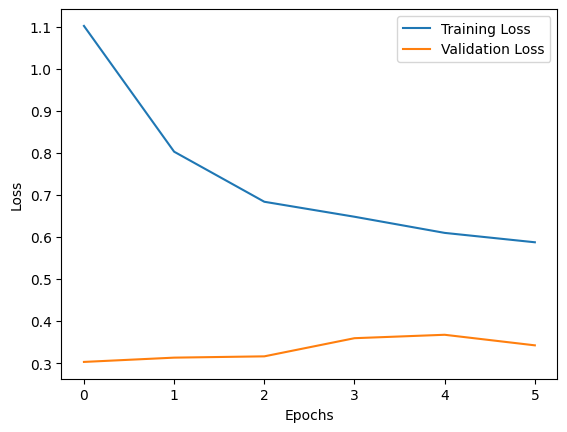

In [24]:
# Define the model
model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(X.shape[1],)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)

# You can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

33.08029806816387

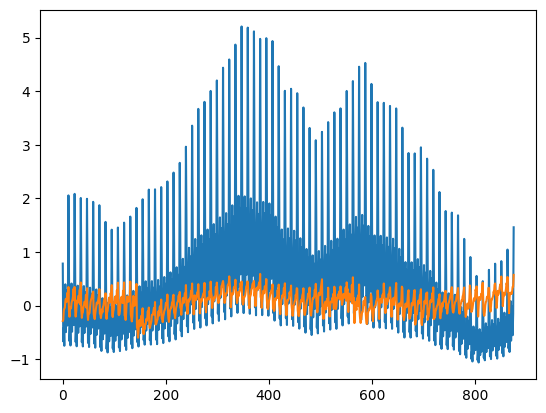

In [26]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

### LSTM - Date

Epoch 1/50
88/88 [==============================] - 5s 14ms/step - loss: 0.8753 - val_loss: 0.3458
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.6020 - val_loss: 0.4113
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.5351 - val_loss: 0.4960
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4923 - val_loss: 0.3923
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4858 - val_loss: 0.4044
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 1.6836
Test Loss: 1.6836217641830444
28/28 [==============================] - 1s 2ms/step


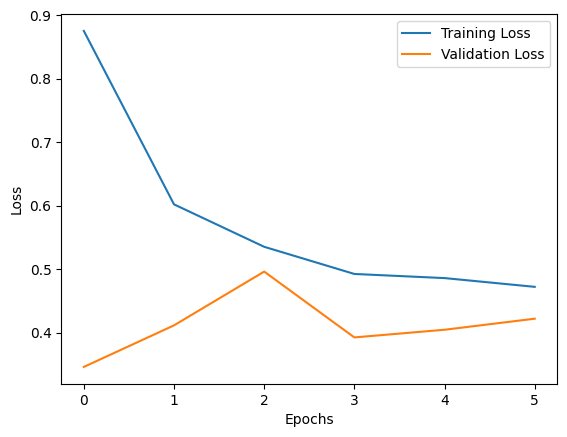

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data["Région"] = encoder.fit_transform(data["Région"])

# Extract features from Date column
data["Year"] = pd.to_datetime(data["Date"]).dt.year
data["Month"] = pd.to_datetime(data["Date"]).dt.month
data["Day"] = pd.to_datetime(data["Date"]).dt.day

# Drop the original Date column
data = data.drop(columns=["Date"])

# Normalize numerical features
scaler = StandardScaler()
data[["Year", "Month", "Day", "Temp", "Emissions"]] = scaler.fit_transform(
    data[["Year", "Month", "Day", "Temp", "Emissions"]]
)

# Split data into features and target
X = data[["Year", "Month", "Day", "Région", "Temp"]]
y = data["Emissions"]

# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential(
    [
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

38.40381180498458

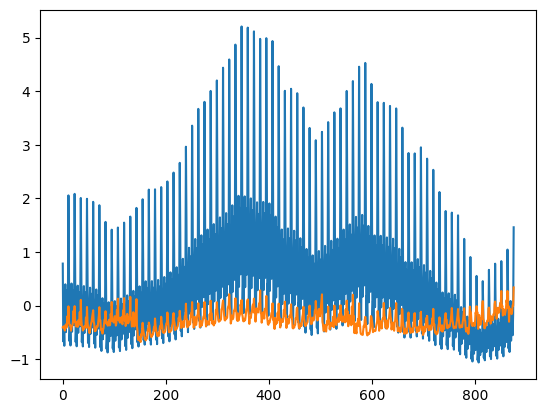

In [29]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

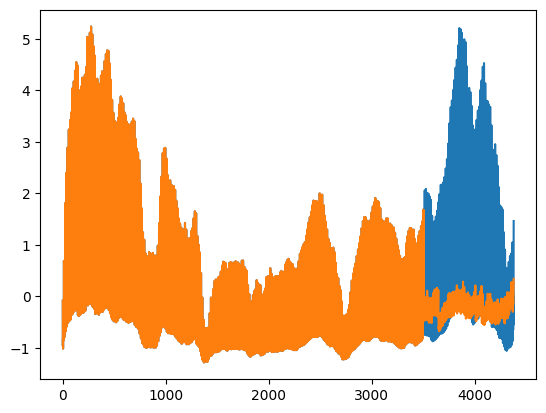

In [30]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

### LSTM - sinus cos transformation

Epoch 1/50
88/88 [==============================] - 5s 16ms/step - loss: 0.8023 - val_loss: 0.3284
Epoch 2/50
88/88 [==============================] - 0s 6ms/step - loss: 0.5340 - val_loss: 0.3142
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.5064 - val_loss: 0.3061
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4919 - val_loss: 0.3018
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4744 - val_loss: 0.3026
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4519 - val_loss: 0.2866
Epoch 7/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4345 - val_loss: 0.2724
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4192 - val_loss: 0.2533
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4178 - val_loss: 0.2525
Epoch 10/50
88/88 [==============================] - 1s 6ms/step - loss: 0.4173 - val_loss: 0.2397
Epoch 11/50
88/88 

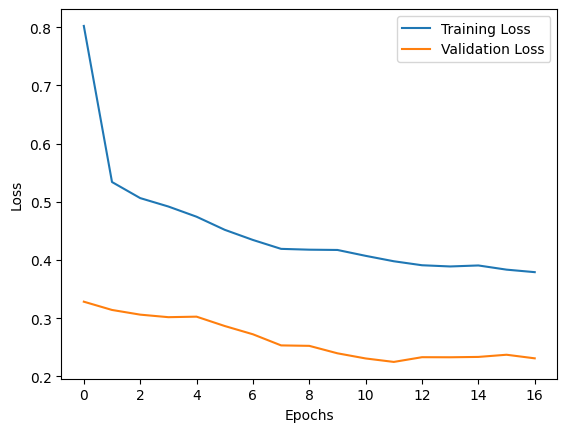

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data["Région"] = encoder.fit_transform(data["Région"])

# Convert Date to sinusoidal and cosinusoidal components
data["Date"] = pd.to_datetime(data["Date"])
data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

# Drop the original Date column
data = data.drop(columns=["Date"])

# Normalize numerical features
scaler = StandardScaler()
var_names = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Région",
    "Temp",
    "Emissions",
]
data[var_names] = scaler.fit_transform(data[var_names])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]


# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential(
    [
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

27.181043273872913

(0.0, 120.0)

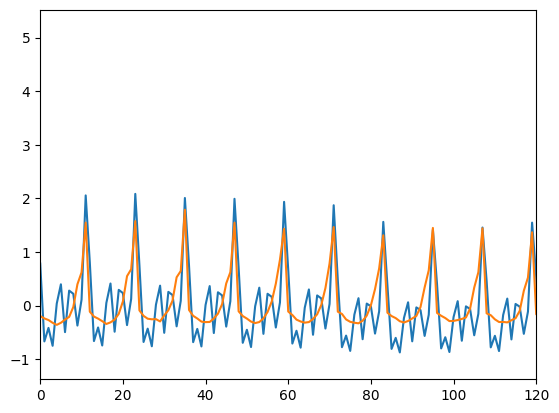

In [33]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())
plt.xlim([0, 12 * 10])

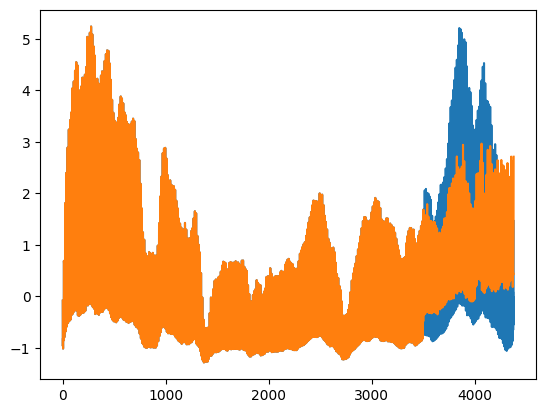

In [34]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 0.843389398922548
Root Mean Squared Error (RMSE): 0.9183623462024932
Mean Absolute Error (MAE): 0.7457745488369221
Coefficient of Determination (R^2): 0.3293961205064414


### LSTM - More variables

Epoch 1/50
88/88 [==============================] - 5s 15ms/step - loss: 0.6367 - val_loss: 0.1647
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1771 - val_loss: 0.0971
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1360 - val_loss: 0.0836
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1282 - val_loss: 0.0944
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1242 - val_loss: 0.1013
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1137 - val_loss: 0.1100
Epoch 7/50
88/88 [==============================] - 0s 6ms/step - loss: 0.1085 - val_loss: 0.1151
Epoch 8/50
28/28 [==============================] - 0s 2ms/step - loss: 0.4394
Test Loss: 0.4393802583217621
28/28 [==============================] - 1s 2ms/step


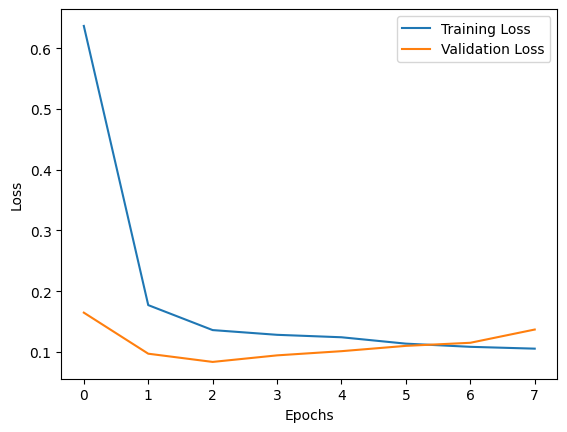

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data["Région"] = encoder.fit_transform(data["Région"])

# Convert Date to sinusoidal and cosinusoidal components
data["Date"] = pd.to_datetime(data["Date"])
data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

# Drop the original Date column
data = data.drop(columns=["Date"])

# Normalize numerical features
scaler = StandardScaler()
var_names = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Région",
    "Temp",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "ce",
    "Emissions",
]
data[var_names] = scaler.fit_transform(data[var_names])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]


# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential(
    [
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)
y_pred_allregions = y_pred

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

19.618794998329236

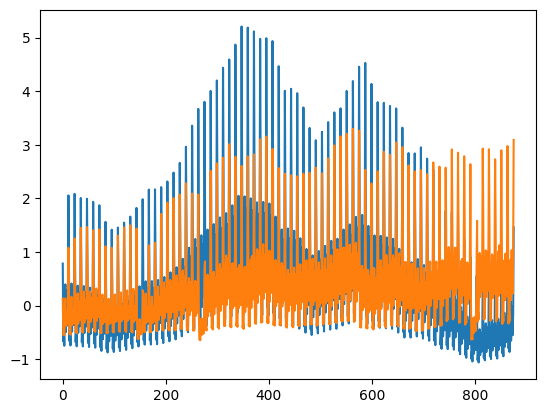

In [38]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

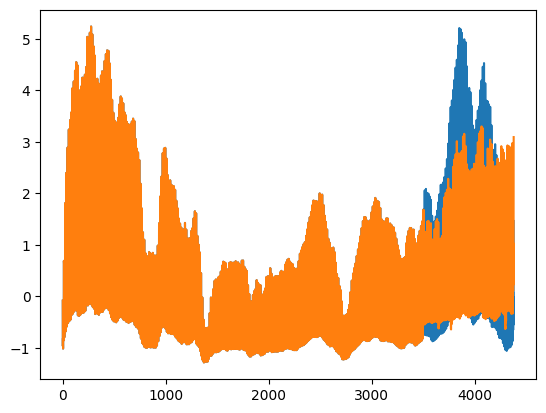

In [39]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 0.4393802707608085
Root Mean Squared Error (RMSE): 0.6628576549763973
Mean Absolute Error (MAE): 0.47990303473246493
Coefficient of Determination (R^2): 0.6506357389344097


## Model - Région par région

### Variables

In [102]:
var_names = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Temp",
    "Région",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "ce",
    "ce1",
    "ce2",
    "ce3",
    "ce4",
    "ce5",
    "ce6",
    "ce7",
    "Temp1",
    "Temp2",
    "Temp3",
    "Temp4",
    "Temp5",
    "Temp6",
    "Temp7",
    "Emissions",
]

scalar_vars = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Temp",
    "ce",
    "ce1",
    "ce2",
    "ce3",
    "ce4",
    "ce5",
    "ce6",
    "ce7",
    "Temp1",
    "Temp2",
    "Temp3",
    "Temp4",
    "Temp5",
    "Temp6",
    "Temp7",
    "Emissions",
]

cat_vars = ["Région", "saison", "week_day", "is_holiday", "is_bank_holiday"]

### LSTM

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 124ms/step - loss: 1.0570 - val_loss: 0.1735
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9653 - val_loss: 0.1431
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.8731 - val_loss: 0.1125
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7709 - val_loss: 0.0860
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6263 - val_loss: 0.0680
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.4980 - val_loss: 0.0615
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3582 - val_loss: 0.0688
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2990 - val_loss: 0.0853
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2608 - val_loss: 0.1044
Epoch 10/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2359 - val_loss: 0.1178
Epoch 11/50
3/3 [========================

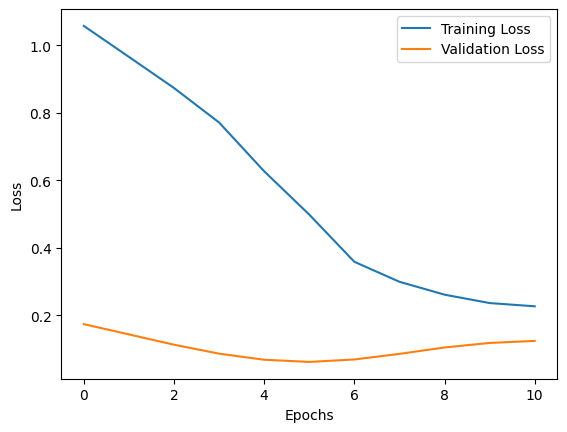

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 129ms/step - loss: 1.0476 - val_loss: 0.1746
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9666 - val_loss: 0.1498
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.8799 - val_loss: 0.1242
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7641 - val_loss: 0.0994
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6646 - val_loss: 0.0789
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5289 - val_loss: 0.0668
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4196 - val_loss: 0.0651
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3430 - val_loss: 0.0729
Epoch 9/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3065 - val_loss: 0.0868
Epoch 10/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2605 - val_loss: 0.1009
Epoch 11/50
8/8 [=======================

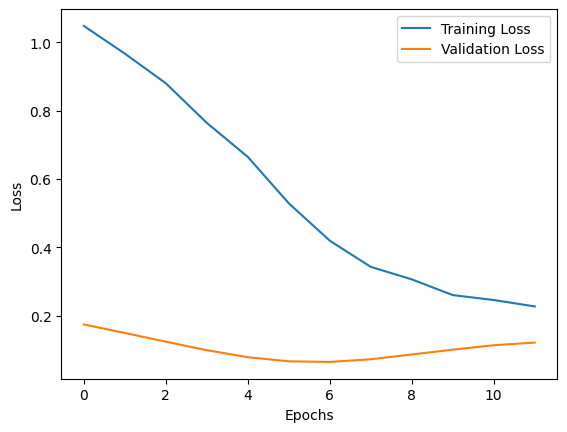

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 141ms/step - loss: 1.0760 - val_loss: 0.1929
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 1.0213 - val_loss: 0.1671
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9590 - val_loss: 0.1401
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.8823 - val_loss: 0.1126
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.7800 - val_loss: 0.0871
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6528 - val_loss: 0.0681
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5434 - val_loss: 0.0597
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.4167 - val_loss: 0.0643
Epoch 9/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3420 - val_loss: 0.0770
Epoch 10/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3065 - val_loss: 0.0897
Epoch 11/50
8/8 [===========================

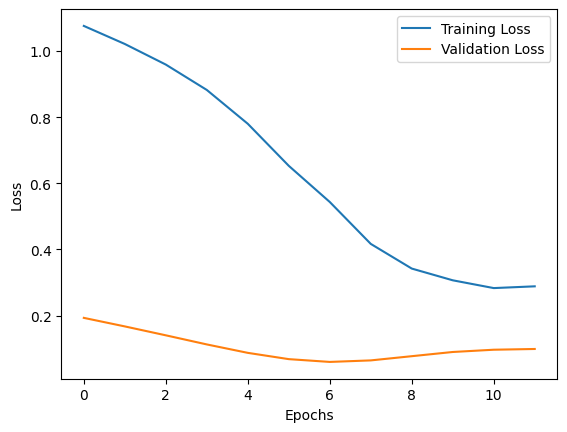

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 138ms/step - loss: 1.0728 - val_loss: 0.1827
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1.0010 - val_loss: 0.1570
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9193 - val_loss: 0.1316
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.8354 - val_loss: 0.1075
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7200 - val_loss: 0.0863
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6042 - val_loss: 0.0705
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.4894 - val_loss: 0.0632
Epoch 8/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3924 - val_loss: 0.0658
Epoch 9/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3112 - val_loss: 0.0741
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3019 - val_loss: 0.0853
Epoch 11/50
8/8 [=========================

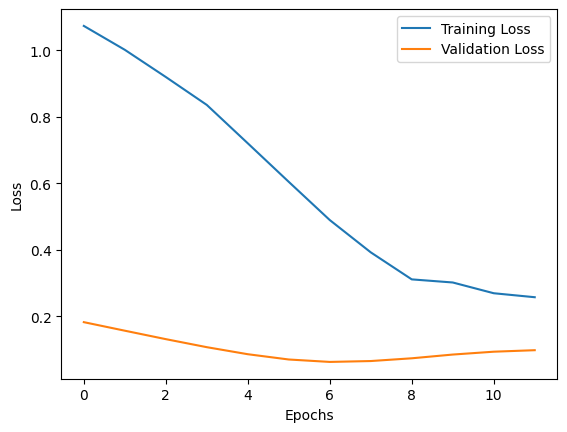

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 163ms/step - loss: 1.0696 - val_loss: 0.1752
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1.0202 - val_loss: 0.1551
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9542 - val_loss: 0.1324
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.8694 - val_loss: 0.1086
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7712 - val_loss: 0.0857
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6494 - val_loss: 0.0691
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5254 - val_loss: 0.0629
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3896 - val_loss: 0.0689
Epoch 9/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3404 - val_loss: 0.0823
Epoch 10/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3098 - val_loss: 0.0953
Epoch 11/50
8/8 [========================

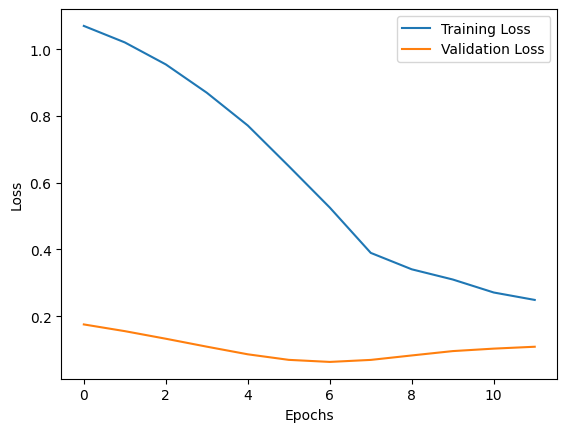

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 121ms/step - loss: 1.0873 - val_loss: 0.1910
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0169 - val_loss: 0.1658
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9340 - val_loss: 0.1415
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.8468 - val_loss: 0.1170
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7359 - val_loss: 0.0934
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6147 - val_loss: 0.0730
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5151 - val_loss: 0.0600
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3901 - val_loss: 0.0576
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3356 - val_loss: 0.0632
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2831 - val_loss: 0.0704
Epoch 11/50
8/8 [=========================

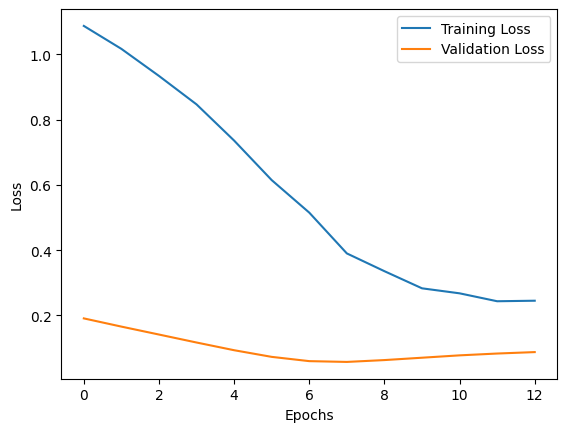

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 149ms/step - loss: 1.0347 - val_loss: 0.1625
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.9621 - val_loss: 0.1361
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.8932 - val_loss: 0.1108
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7851 - val_loss: 0.0870
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6810 - val_loss: 0.0695
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.5395 - val_loss: 0.0616
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.4458 - val_loss: 0.0661
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3512 - val_loss: 0.0816
Epoch 9/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3005 - val_loss: 0.1007
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2963 - val_loss: 0.1180
Epoch 11/50
3/3 [======================

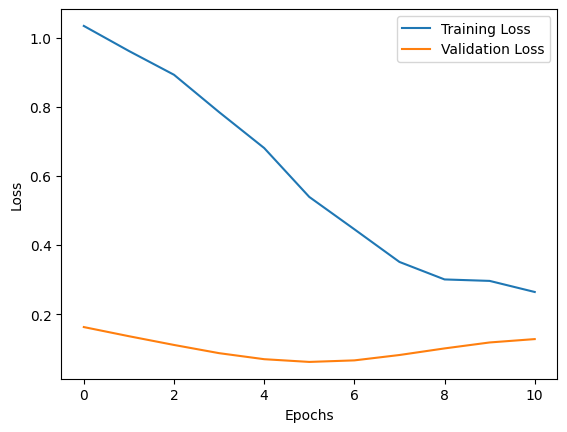

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 137ms/step - loss: 1.0884 - val_loss: 0.1954
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 1.0313 - val_loss: 0.1735
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9671 - val_loss: 0.1513
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.8885 - val_loss: 0.1252
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7944 - val_loss: 0.0992
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6780 - val_loss: 0.0773
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5496 - val_loss: 0.0663
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.4170 - val_loss: 0.0666
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3467 - val_loss: 0.0791
Epoch 10/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3009 - val_loss: 0.0967
Epoch 11/50
8/8 [======================

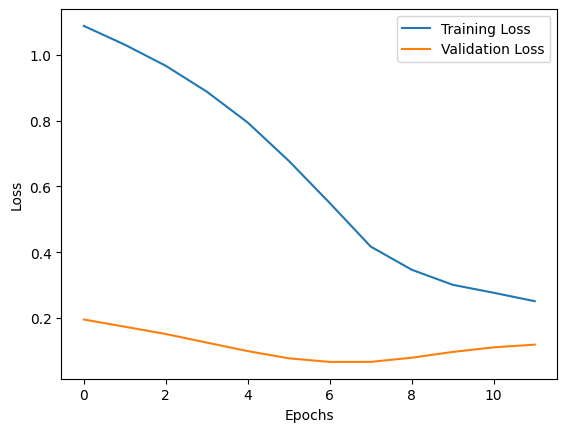

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 152ms/step - loss: 1.0569 - val_loss: 0.1708
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9732 - val_loss: 0.1452
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.8822 - val_loss: 0.1186
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7792 - val_loss: 0.0926
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.6555 - val_loss: 0.0692
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5166 - val_loss: 0.0537
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.4079 - val_loss: 0.0495
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3127 - val_loss: 0.0542
Epoch 9/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2857 - val_loss: 0.0645
Epoch 10/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2495 - val_loss: 0.0774
Epoch 11/50
8/8 [=======================

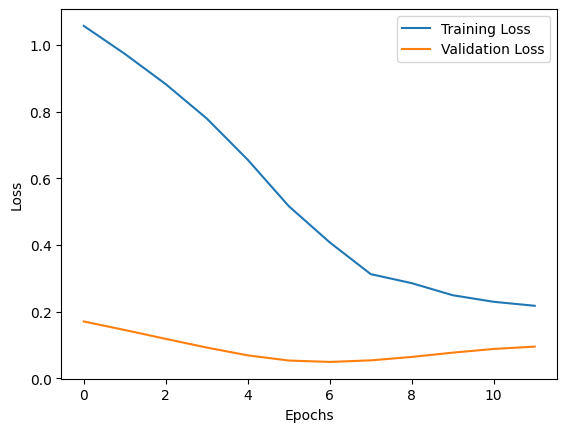

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 118ms/step - loss: 1.0670 - val_loss: 0.1794
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1.0056 - val_loss: 0.1582
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.9268 - val_loss: 0.1342
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.8337 - val_loss: 0.1063
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7193 - val_loss: 0.0803
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5897 - val_loss: 0.0618
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.4721 - val_loss: 0.0563
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3798 - val_loss: 0.0644
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3193 - val_loss: 0.0794
Epoch 10/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2867 - val_loss: 0.0901
Epoch 11/50
8/8 [=========================

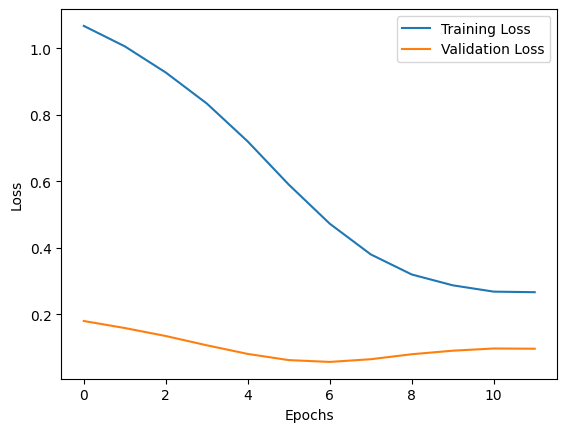

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 138ms/step - loss: 1.1210 - val_loss: 0.1848
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 1.0480 - val_loss: 0.1580
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9653 - val_loss: 0.1318
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.8861 - val_loss: 0.1057
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7658 - val_loss: 0.0830
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6349 - val_loss: 0.0679
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.4819 - val_loss: 0.0655
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3594 - val_loss: 0.0790
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2789 - val_loss: 0.1037
Epoch 10/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2440 - val_loss: 0.1306
Epoch 11/50
8/8 [=======================

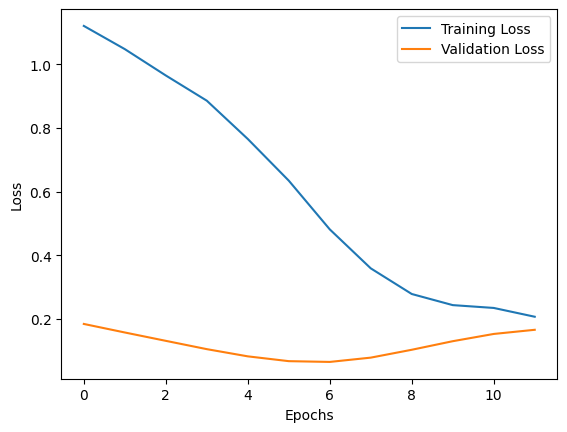

Epoch 1/50


c:\Users\samib\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 5s 124ms/step - loss: 1.0442 - val_loss: 0.1793
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9744 - val_loss: 0.1523
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.8900 - val_loss: 0.1242
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.7822 - val_loss: 0.0991
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6477 - val_loss: 0.0804
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5299 - val_loss: 0.0694
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.4058 - val_loss: 0.0686
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3257 - val_loss: 0.0754
Epoch 9/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2888 - val_loss: 0.0856
Epoch 10/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2607 - val_loss: 0.0930
Epoch 11/50
8/8 [==========================

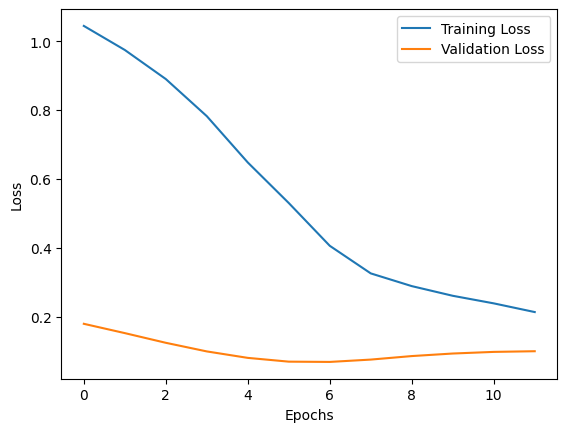

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

y_train_regions = dict()
y_test_regions = dict()
y_pred_regions = dict()

for reg in REGIONS:
    data = df_processed[df_processed["Région"] == reg].copy()

    # Convert Date to sinusoidal and cosinusoidal components
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
    data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
    data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
    data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
    data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
    data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

    # Drop the original Date column
    data = data.drop(columns=["Date"])

    # Normalize numerical features
    scaler = StandardScaler()
    var_names = [
        "Day_sin",
        "Day_cos",
        "Month_sin",
        "Month_cos",
        "Year_sin",
        "Year_cos",
        "Temp",
        "saison",
        "week_day",
        "is_holiday",
        "is_bank_holiday",
        "ce",
        "Emissions",
    ]
    data[var_names] = scaler.fit_transform(data[var_names])

    # Split data into features and target
    X = data[var_names[:-1]]
    y = data[var_names[-1]]

    # Reshape features for LSTM input [samples, timesteps, features]
    X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

    # Define the LSTM model
    model = Sequential(
        [
            LSTM(
                64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True
            ),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(1),
        ]
    )

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
    )

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")

    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_regions[reg] = y_pred
    y_train_regions[reg] = y_train
    y_test_regions[reg] = y_test

    # Optionally, you can inverse scale the predictions if necessary
    # predictions = scaler.inverse_transform(predictions)

    # Optionally, you can plot the training and validation loss to observe the training progress
    import matplotlib.pyplot as plt

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [42]:
index = 0
reg = REGIONS[index]
y_pred = y_pred_regions[reg].ravel()
y_test = y_test_regions[reg].ravel()
y_train = y_train_regions[reg].ravel()
y = np.concatenate((y_train, y_test))

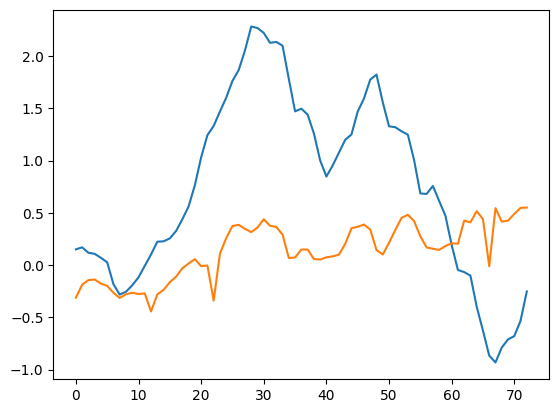

In [43]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

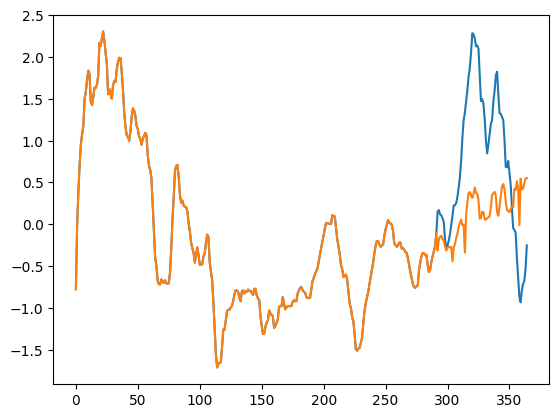

In [44]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 1.0947613872428994
Root Mean Squared Error (RMSE): 1.0463084570254124
Mean Absolute Error (MAE): 0.8984316327460243
Coefficient of Determination (R^2): -0.4102890195590836


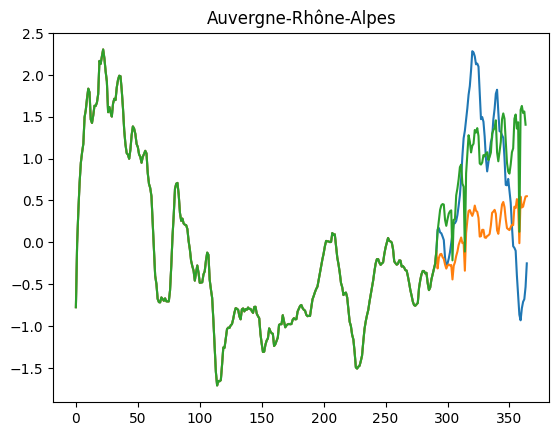

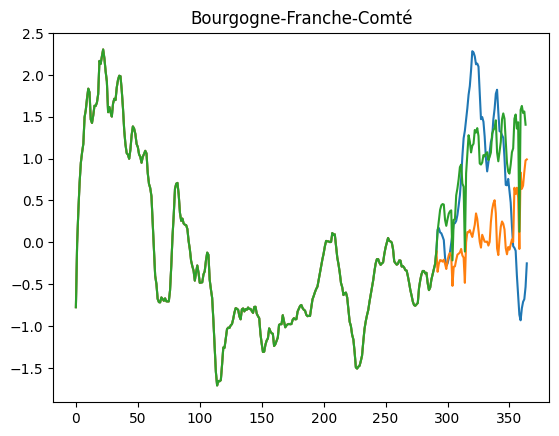

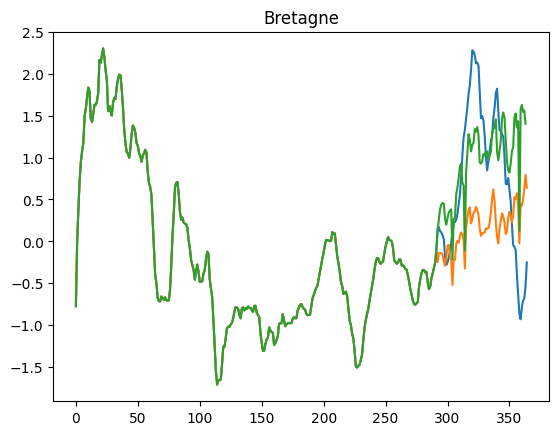

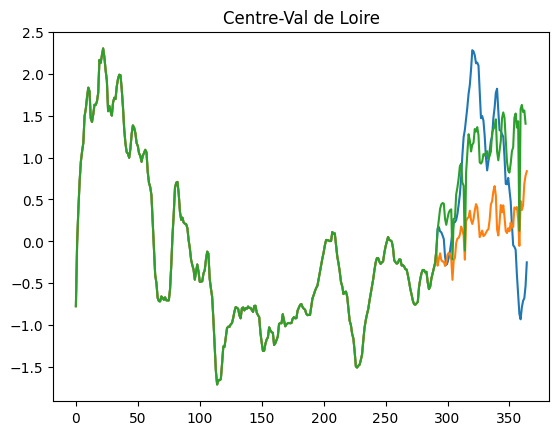

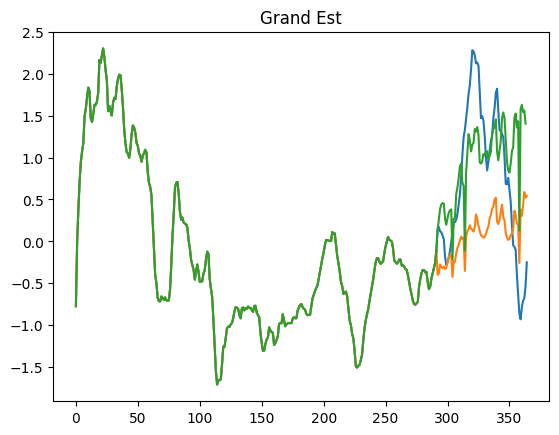

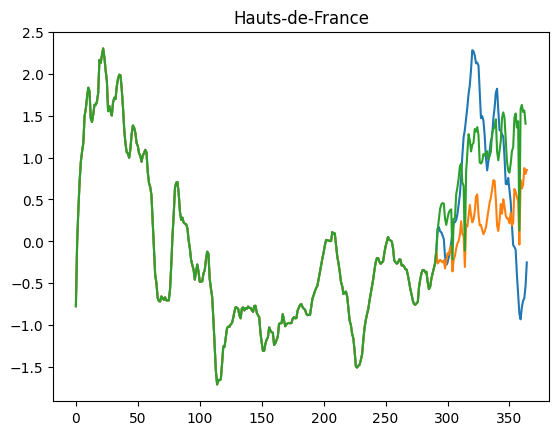

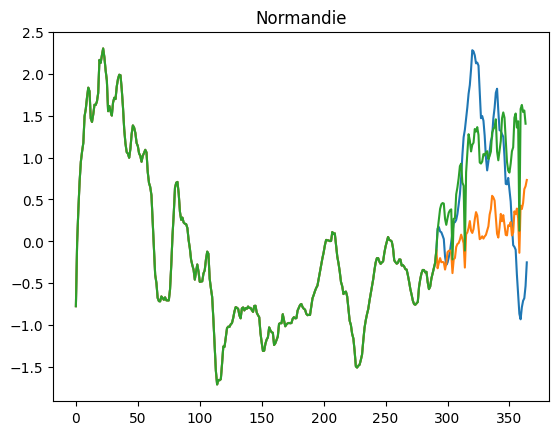

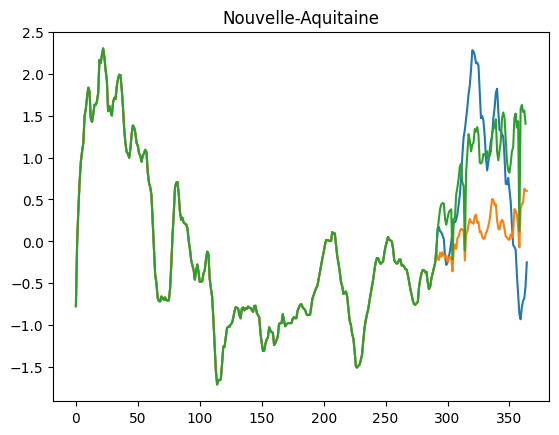

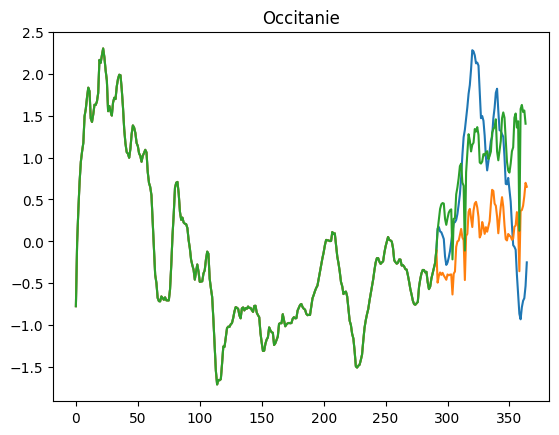

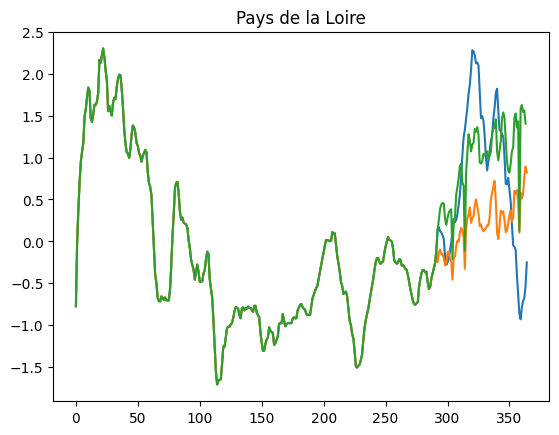

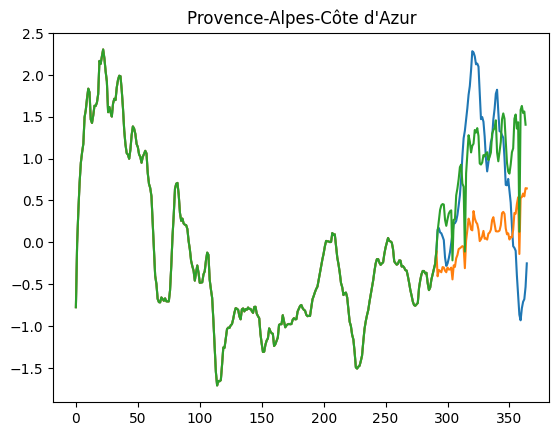

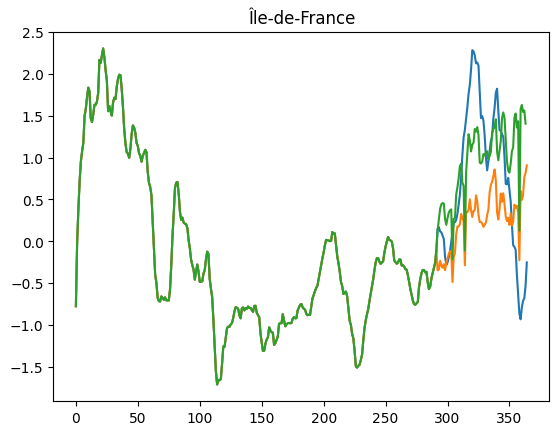

In [46]:
for reg in REGIONS:
    y_pred = y_pred_regions[reg].ravel()
    y_test = y_test_regions[reg].ravel()
    y_train = y_train_regions[reg].ravel()
    y = np.concatenate((y_train, y_test))

    plt.plot(y)
    plt.plot(np.concatenate((y_train, y_pred)))
    plt.plot(
        np.concatenate(
            (y_train, y_pred_allregions[12 * np.arange(72) + index].ravel())
        )
    )
    plt.title(reg)
    plt.show()

### Catboost

In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


y_train_regions = dict()
y_test_regions = dict()
y_pred_regions = dict()

for reg in REGIONS:
    data = df_processed[df_processed["Région"] == reg].copy()

    # Encode categorical variables
    encoder = LabelEncoder()
    for var in cat_vars:
        data[var] = encoder.fit_transform(data[var])

    # Convert Date to sinus and cosinus transform
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
    data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
    data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
    data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
    data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
    data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

    # Drop the original Date column
    data = data.drop(columns=["Date"])

    # Normalize numerical features
    scaler = StandardScaler()
    data[scalar_vars] = scaler.fit_transform(data[scalar_vars])

    # Split data into features and target
    X = data[var_names[:-1]]
    y = data[var_names[-1]]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Define CatBoost model
    model = CatBoostRegressor(
        iterations=1000, learning_rate=0.1, depth=6, loss_function="MAPE"
    )

    # Train CatBoost model
    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        early_stopping_rounds=50,
    )

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_regions[reg] = y_pred
    y_train_regions[reg] = y_train
    y_test_regions[reg] = y_test

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

0:	learn: 0.5251657	test: 0.9111448	best: 0.9111448 (0)	total: 3.17ms	remaining: 3.17s
100:	learn: 0.0746870	test: 0.7370135	best: 0.7226592 (51)	total: 242ms	remaining: 2.16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7226591546
bestIteration = 51

Shrink model to first 52 iterations.
Mean Squared Error: 1.1998881961047567
0:	learn: 0.5322485	test: 0.9115147	best: 0.9115147 (0)	total: 3.17ms	remaining: 3.17s
100:	learn: 0.0762289	test: 0.7310757	best: 0.7310757 (100)	total: 242ms	remaining: 2.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.728093747
bestIteration = 117

Shrink model to first 118 iterations.
Mean Squared Error: 1.1050715972458534
0:	learn: 0.5258818	test: 0.9059423	best: 0.9059423 (0)	total: 2.92ms	remaining: 2.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7656784398
bestIteration = 19

Shrink model to first 20 iterations.
Mean Squared Error: 1.4607054280454905
0:	learn: 0.5276956	test: 0.910834

In [115]:
index = 0
reg = REGIONS[index]
y_pred = y_pred_regions[reg].ravel()
y_test = y_test_regions[reg].ravel()
y_train = y_train_regions[reg].ravel()
y = np.concatenate((y_train, y_test))

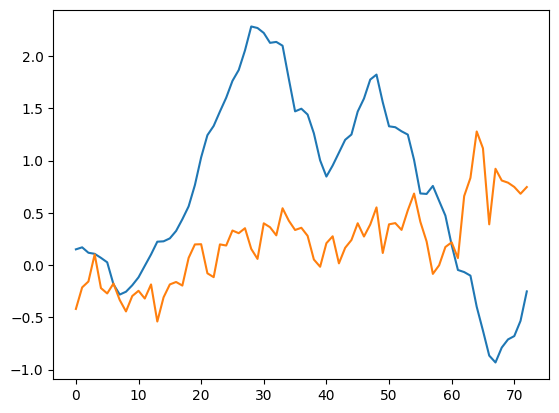

In [116]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

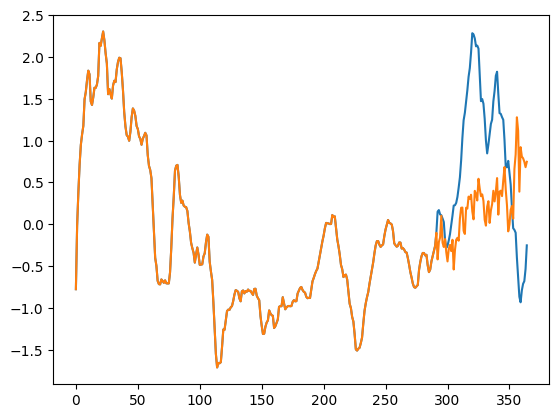

In [117]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 1.1998881961047567
Root Mean Squared Error (RMSE): 1.0953940825587642
Mean Absolute Error (MAE): 0.937724467703936
Coefficient of Determination (R^2): -0.5457150456564666


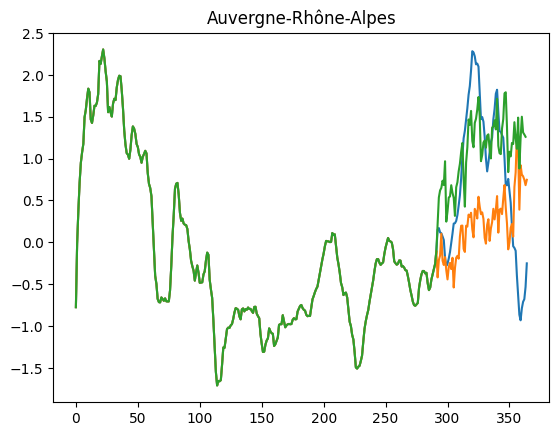

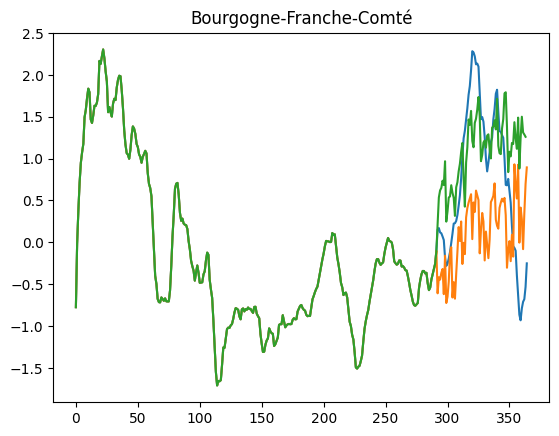

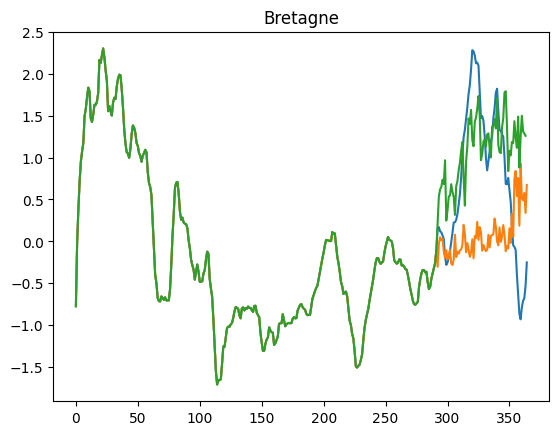

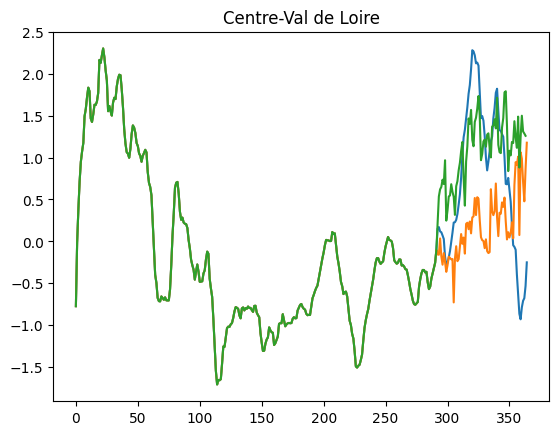

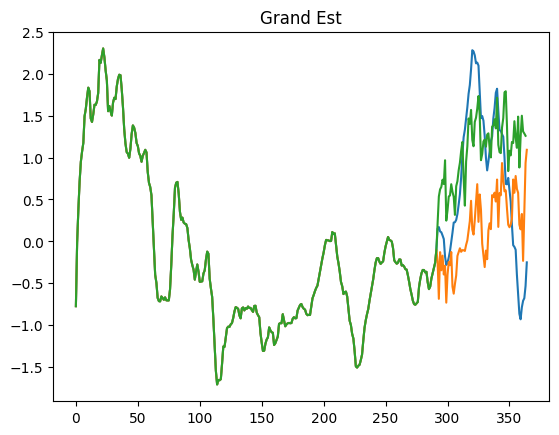

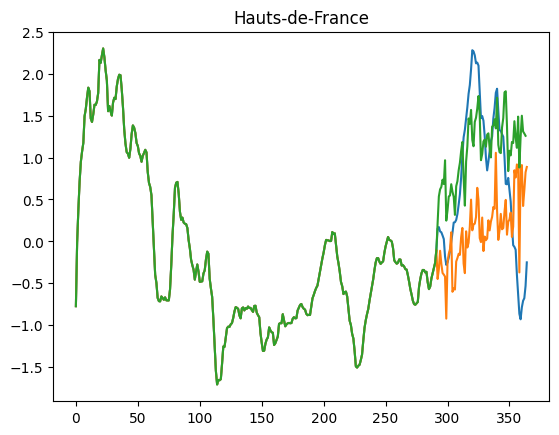

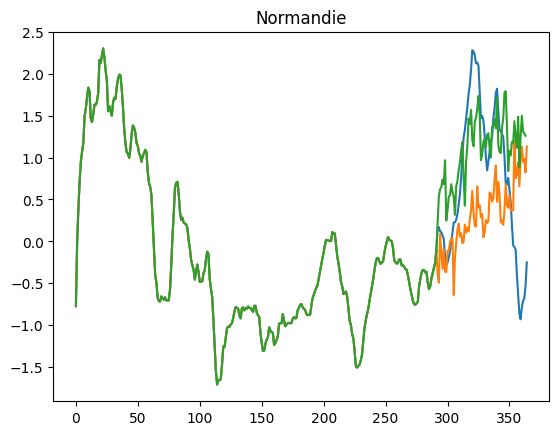

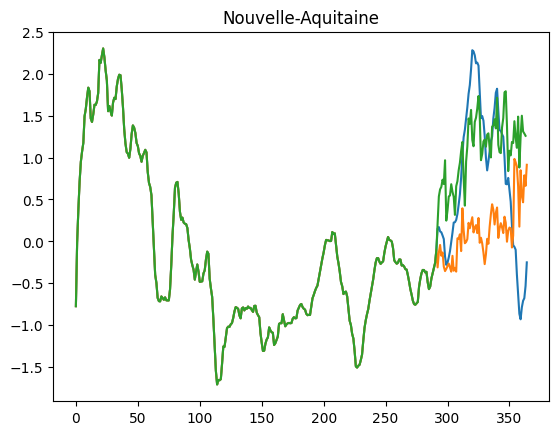

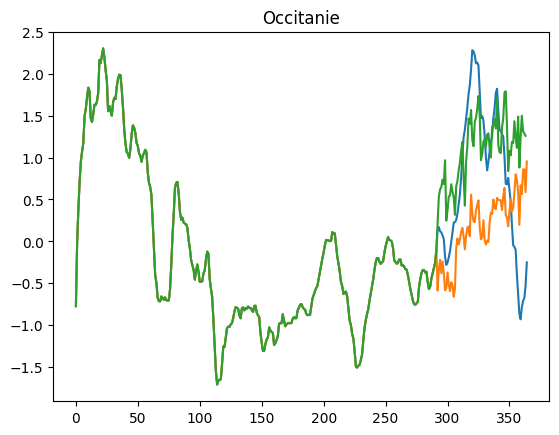

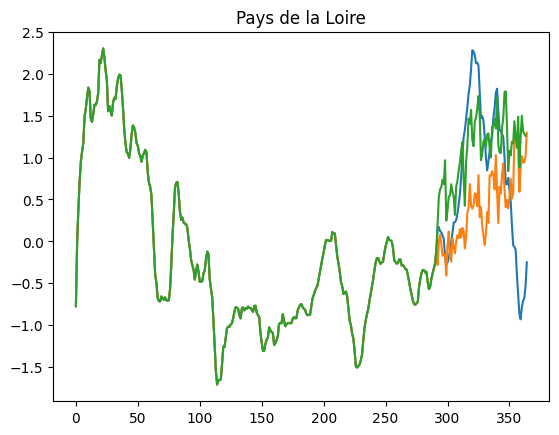

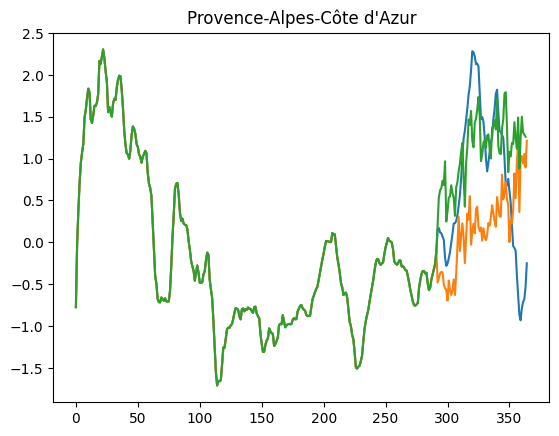

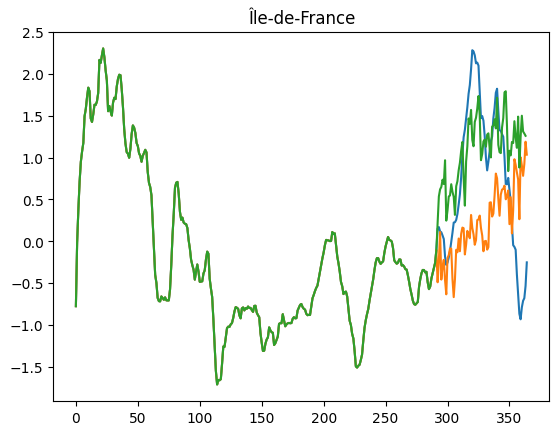

In [119]:
for reg in REGIONS:
    y_pred = y_pred_regions[reg].ravel()
    y_test = y_test_regions[reg].ravel()
    y_train = y_train_regions[reg].ravel()
    y = np.concatenate((y_train, y_test))

    plt.plot(y)
    plt.plot(np.concatenate((y_train, y_pred)))
    plt.plot(
        np.concatenate(
            (y_train, y_pred_allregions[12 * np.arange(72) + index].ravel())
        )
    )
    plt.title(reg)
    plt.show()

## Final Models

### LSTM

In [64]:
var_names = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Temp",
    "Région",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "ce",
    "ce1",
    "ce2",
    "ce3",
    "ce4",
    "ce5",
    "ce6",
    "ce7",
    "Temp1",
    "Temp2",
    "Temp3",
    "Temp4",
    "Temp5",
    "Temp6",
    "Temp7",
    "Emissions",
]

scalar_vars = [
    "Day_sin",
    "Day_cos",
    "Month_sin",
    "Month_cos",
    "Year_sin",
    "Year_cos",
    "Temp",
    "ce",
    "ce1",
    "ce2",
    "ce3",
    "ce4",
    "ce5",
    "ce6",
    "ce7",
    "Temp1",
    "Temp2",
    "Temp3",
    "Temp4",
    "Temp5",
    "Temp6",
    "Temp7",
    "Emissions",
]

cat_vars = ["Région", "saison", "week_day", "is_holiday", "is_bank_holiday"]

Epoch 1/50
88/88 [==============================] - 6s 14ms/step - loss: 0.6656 - val_loss: 0.1475
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2104 - val_loss: 0.1029
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1550 - val_loss: 0.1281
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1478 - val_loss: 0.1233
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1453 - val_loss: 0.1418
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1348 - val_loss: 0.1276
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.3619
Test Loss: 0.3619469404220581
28/28 [==============================] - 1s 3ms/step


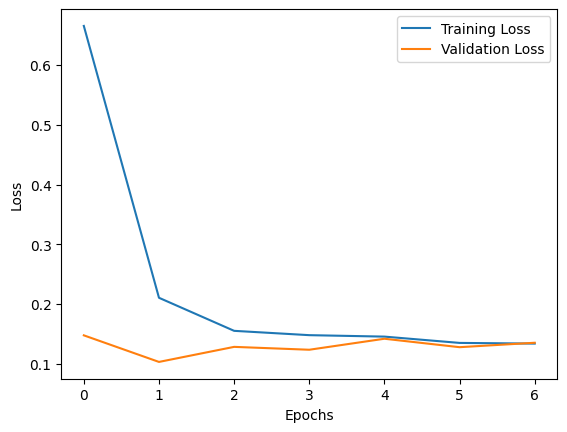

In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
for var in cat_vars:
    data[var] = encoder.fit_transform(data[var])

# Convert Date to sinusoidal and cosinusoidal components
data["Date"] = pd.to_datetime(data["Date"])
data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

# Drop the original Date column
data = data.drop(columns=["Date"])

# Normalize numerical features
scaler = StandardScaler()
data[scalar_vars] = scaler.fit_transform(data[scalar_vars])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]


# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential(
    [
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)
y_pred_allregions = y_pred

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [75]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

17.806333515947134

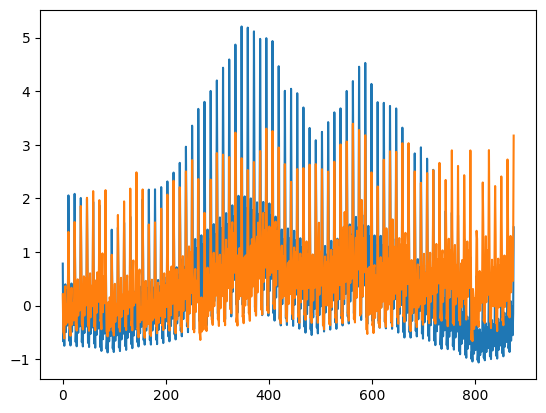

In [76]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

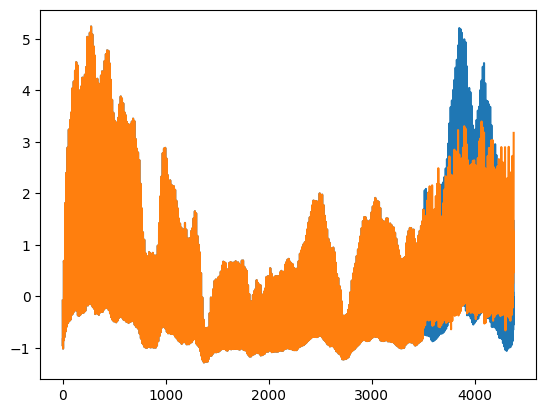

In [77]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 0.36194693296934044
Root Mean Squared Error (RMSE): 0.6016202564486509
Mean Absolute Error (MAE): 0.43597805359639996
Coefficient of Determination (R^2): 0.7122052782141681


### Catboost

In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load data
data = df_processed.copy()

# Encode categorical variables
encoder = LabelEncoder()
for var in cat_vars:
    data[var] = encoder.fit_transform(data[var])

# Convert Date to sinus and cosinus transform
data["Date"] = pd.to_datetime(data["Date"])
data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

# Drop the original Date column
data = data.drop(columns=["Date"])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define CatBoost model
model = CatBoostRegressor(
    iterations=1000, learning_rate=0.1, depth=6, loss_function="MAPE"
)

# Train CatBoost model
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    early_stopping_rounds=50,
)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

0:	learn: 0.0027716	test: 0.0042894	best: 0.0042894 (0)	total: 12.6ms	remaining: 12.6s
100:	learn: 0.0004539	test: 0.0026579	best: 0.0026579 (100)	total: 444ms	remaining: 3.95s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002656297319
bestIteration = 103

Shrink model to first 104 iterations.
Mean Squared Error: 1.2679939076425225e-05


In [130]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

0.10539272570224426

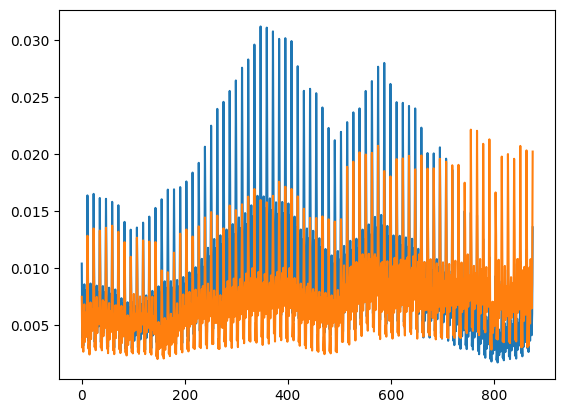

In [131]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

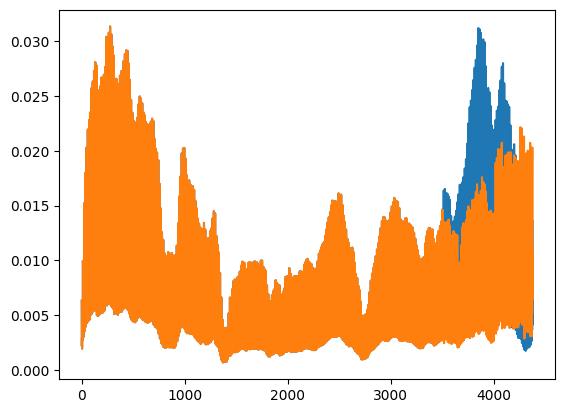

In [132]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 1.2679939076425225e-05
Root Mean Squared Error (RMSE): 0.0035608902084205327
Mean Absolute Error (MAE): 0.002656297328662266
Coefficient of Determination (R^2): 0.5435827467837913


### Xgboost

In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load data
data = df_processed.copy()

# Encode categorical variables
encoder = LabelEncoder()
for var in cat_vars:
    data[var] = encoder.fit_transform(data[var])

# Convert Date to sinus and cosinus transform
data["Date"] = pd.to_datetime(data["Date"])
data["Day_sin"] = np.sin(2 * np.pi * data["Date"].dt.day / 31)
data["Day_cos"] = np.cos(2 * np.pi * data["Date"].dt.day / 31)
data["Month_sin"] = np.sin(2 * np.pi * data["Date"].dt.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Date"].dt.month / 12)
data["Year_sin"] = np.sin(2 * np.pi * data["Date"].dt.year)
data["Year_cos"] = np.cos(2 * np.pi * data["Date"].dt.year)

# Drop the original Date column
data = data.drop(columns=["Date"])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train Xgboost model
model = XGBRegressor(objective="reg:squarederror", random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 7.0667274300272484e-06


In [134]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

0.10539272570224426

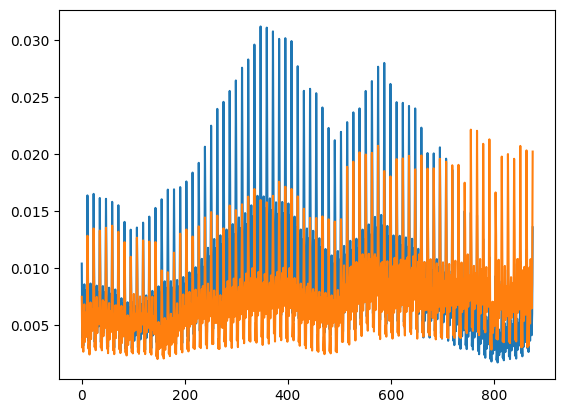

In [135]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

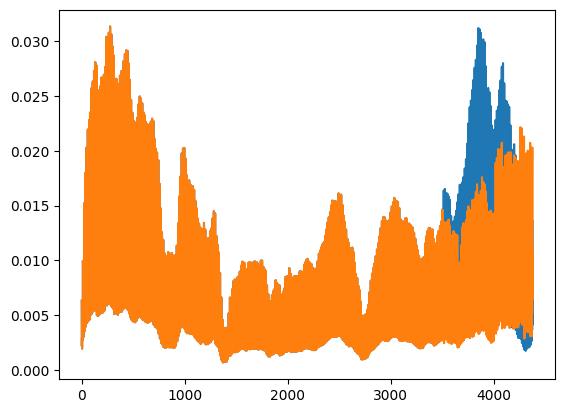

In [136]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(), y_pred.ravel())))
plt.show()

In [137]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

Mean Squared Error (MSE): 1.2679939076425225e-05
Root Mean Squared Error (RMSE): 0.0035608902084205327
Mean Absolute Error (MAE): 0.002656297328662266
Coefficient of Determination (R^2): 0.5435827467837913
